In [1]:
import random

import numpy as np

from src.modules.training.datasets.main_dataset import MainDataset
from src.utils.setup import setup_data
# Import all important ML packages.
from src.utils.stratified_splitter import StratifiedSplitter

## EEG

### Load in all the data

In [2]:
#Start by setting up the data.
path = "../../data/raw"
X, y = setup_data(path)

### Create a dataset

In [3]:
import pickle
import os

#Sample 10000 random indices from the training dataset and 2000 from the validation dataset.
random.seed(42)

#Pickle X_train, X_test, y_train, y_test  as 1 tuple if it does not exist yet.
n_samples = 5000

eeg_path = "../../data/raw/train_eegs"
meta_path = "../../data/raw/train.csv"
cache_path = "../../data/cache"

if not os.path.exists("train_test20k.pkl") or n_samples != 20000:
    #Start by setting up the data. Do not run if you already have the pickled data. 

    X, y = setup_data(eeg_path=eeg_path, metadata_path=meta_path, cache_path=cache_path, spectrogram_path=None)
    
    #Create a dataset
    splitter = StratifiedSplitter(n_splits=5)
    train_indices, test_indices = splitter.split(X.meta, y)[0]
    
    train_dataset = MainDataset("eeg")
    test_dataset = MainDataset("eeg")
    
    train_dataset.setup(X, y, train_indices, subsample_data=True)
    test_dataset.setup(X, y, test_indices, subsample_data=True)
    
    train_sample = random.sample(list(range(len(train_dataset.indices))), n_samples)
    val_sample = random.sample(list(range(len(test_dataset.indices))), len(test_dataset.indices))

    X_train = np.array([train_dataset.__getitem__(i)[0] for i in train_sample])
    y_train = np.array([train_dataset.__getitem__(i)[1] for i in train_sample])

    X_test = np.array([test_dataset.__getitem__(i)[0] for i in val_sample])
    y_test = np.array([test_dataset.__getitem__(i)[1] for i in val_sample])
    with open("train_test20k.pkl", "wb") as f:
        pickle.dump((X_train, X_test, y_train, y_test), f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open("train_test20k.pkl", "rb") as f:
        X_train, X_test, y_train, y_test = pickle.load(f)

### Feature engineering

In [4]:
# Let's try statistical features such as rolling mean to start with on all channels 
# and then try to use the rolling mean on the channels that are most important.

In [5]:

import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm


def channel_selection(data, channels):
    """
    Selects the specified channels from a 3D numpy array.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        channels (list): The list of channels to select.
        
    Returns:
        numpy.ndarray: The data with the selected channels.
    """
    return data[:, :, channels]


def apply_downsampling(data, factor):
    """
    Downsamples a 3D numpy array by averaging over windows of the specified factor.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        factor (int): The downsampling factor.
        
    Returns:
        numpy.ndarray: The downsampled data.
    """
    reshaped_data = data.reshape(data.shape[0], data.shape[1] // factor, factor, data.shape[2])

    # Compute the mean along the new axis that represents the blocks to be averaged
    downsampled_data = reshaped_data.mean(axis=2)

    return downsampled_data


def apply_rolling_operation(data, window_size, operation):
    """
    Applies a rolling operation (e.g., mean, std, min, max) to a 3D numpy array.
    
    Parameters:
        data (numpy.ndarray): The input data of shape (samples, sequence_length, channels).
        window_size (int): The size of the rolling window.
        operation (callable): The operation to apply within the rolling window.
        
    Returns:
        numpy.ndarray: The data with the rolling operation applied.
    """
    # Initialize the result array with NaNs to preserve original shape
    result = np.full(data.shape, np.nan)

    # Apply the rolling operation to each sample and channel
    for sample_idx in tqdm(range(data.shape[0])):
        for channel_idx in range(data.shape[2]):
            sequence = data[sample_idx, :, channel_idx]
            # Use sliding_window_view to create rolling windows
            windows = sliding_window_view(sequence, window_shape=window_size)
            # Apply the operation across the windows' axis (axis=-1) and assign to the result
            # Center the result of the operation in the middle of the window
            operation_result = operation(windows, axis=-1)
            start_index = window_size // 2
            end_index = start_index + operation_result.shape[0]
            result[sample_idx, start_index:end_index, channel_idx] = operation_result

            #Forward and backward fill the NaNs
            result[sample_idx, :, channel_idx] = pd.Series(result[sample_idx, :, channel_idx]).fillna(method="ffill").fillna(method="bfill")
    return result


def rolling_plot(X_train, X_test, window_size, operation):
    #Create a plot before and after.
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    #Plot the original data for the first sample and channel
    ax[0].plot(X_train[0, :, 0])
    ax[0].set_title("Original data")

    # Assuming X_train and X_test are your datasets
    X_train = apply_rolling_operation(X_train, window_size, operation)
    X_test = apply_rolling_operation(X_test, window_size, operation)

    #Plot the transformed data for the first sample and channel
    ax[1].plot(X_train[0, :, 0])
    ax[1].set_title(f"Transformed data - rolling {str(operation)} with window size {window_size}")

    plt.show()

    return X_train, X_test

### Preprocess the data

In [6]:
#Remove the time dimension by flattening the data from (n, sequence_length, channels) to (n*sequence_length, channels).
def preprocess(X_train, X_test, y_train, y_test):
    sequence_length = X_train.shape[1]

    X_train = X_train.reshape(-1, X_train.shape[2])
    X_test = X_test.reshape(-1, X_test.shape[2])

    #Also process the labels from size (n, channels) to (n*sequence_length, channels).
    y_train = np.repeat(y_train, repeats=sequence_length, axis=0)
    y_test = np.repeat(y_test, repeats=sequence_length, axis=0)

    #Clip the data between -1024 and 1024.
    X_train = np.clip(X_train, -1024, 1024)
    X_test = np.clip(X_test, -1024, 1024)

    #Divide the data by 32
    X_train = X_train / 32
    X_test = X_test / 32

    #Set NaN to 0
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)

    #Divide the labels by the sum of the labels to get a probability distribution.
    y_train = y_train / np.sum(y_train, axis=1).reshape(-1, 1)
    y_test = y_test / np.sum(y_test, axis=1).reshape(-1, 1)

    #Randomly shuffle train data
    np.random.seed(42)
    p = np.random.permutation(len(X_train))
    X_train = X_train[p]
    y_train = y_train[p]

    #One hot encode the labels
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

    return X_train, X_test, y_train, y_test

In [7]:
import xgboost as xgb


def train(X_train, X_test, y_train, y_test):
    #Create a model
    model = xgb.XGBClassifier(num_class=6, n_estimators=100, max_depth=10, learning_rate=0.1, verbosity=2, early_stopping_rounds=10)
    # Use early stopping to stop the training if the validation score does not improve for 10 rounds.
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    return model

In [8]:
#Calculate the accuracy and create a confusion matrix with seaborn
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from src.scoring.kldiv import KLDiv

def plot_confusion_matrix(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))

    #Set the axis labels
    #Create the confusion matrix
    #Take the argmax of the probabilities to get the predicted class
    y_test_final = np.argmax(y_test, axis=1)
    y_pred_final = np.argmax(y_pred, axis=1)
    print(y_test.shape, y_pred.shape)
    kldiv = KLDiv()
    print(f"KLDiv: {kldiv(y_test, y_pred)}")
    print(f"Classification accuracy:  {accuracy_score(y_test_final, y_pred_final)}")
    
    
    
    sns.heatmap(confusion_matrix(y_test_final, y_pred_final), annot=True, fmt="d", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    #Set the labels
    ax.set_xticklabels(["Seizure", "Lpd", "Gpd", "Lrda", "Grda", "Other"])
    ax.set_yticklabels(["Seizure", "Lpd", "Gpd", "Lrda", "Grda", "Other"])
    plt.show()


In [9]:
def plot_feature_importances(model, feature_names, tsfresh=False):
    #Plot the feature importances with xgboost horizontally
    fig, ax = plt.subplots(1, 2, figsize=(35, 10))

    xgb.plot_importance(model, ax=ax[0], importance_type="weight")
    if not tsfresh:
        ax[0].set_yticklabels(feature_names)

    #Show plots/brain.png on the right
    ax[1].imshow(plt.imread("../../plots/brain.png"))

In [10]:
def pipeline(X_train, X_test, y_train, y_test):
    #Channel selection
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    selected_c = all_channels
    channels = [channel_dict[c] for c in selected_c]
    window_size = 175
    operation = np.std

    #Select the channels
    X_train = channel_selection(X_train, channels)
    X_test = channel_selection(X_test, channels)

    #Downsample the data
    X_train = apply_downsampling(X_train, 10)
    X_test = apply_downsampling(X_test, 10)

    #Apply the rolling operation
    X_train, X_test = rolling_plot(X_train, X_test, window_size, operation)

    #Now preprocess the data
    X_train, X_test, y_train, y_test = preprocess(X_train, X_test, y_train, y_test)

    #Train the model
    model = train(X_train, X_test, y_train, y_test)

    #Make predictions
    y_pred = model.predict(X_test)

    #Plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    #Plot the feature importances
    feature_names = np.array(X.eeg[list(X.eeg.keys())[0]].columns)[channels]
    plot_feature_importances(model, feature_names)

In [11]:
#Run the pipeline
#pipeline(X_train, X_test, y_train, y_test)

In [12]:
# Now lets use tsfresh for feature engineering

def preprocess_to_df(X, all_channels):
    
    #Clip the data between -1024 and 1024.
    X = np.clip(X, -1024, 1024)
    #Divide the data by 32
    X = X / 32
    #Set NaN to 0
    X = np.nan_to_num(X)
    print(X.shape)
    
    id = np.repeat(range(X.shape[0]), X.shape[1])
    X = X.reshape(-1, X.shape[2])
    df = pd.DataFrame(X, columns=all_channels)
    del X
    df["id"] = id
    return df

def apply_tsfresh(df):
    from tsfresh import extract_features
    from tsfresh.feature_extraction import MinimalFCParameters
    
    #Extract the features
    features = extract_features(df, column_id="id", default_fc_parameters=MinimalFCParameters())
    return features

def preprocess_tf(y):
    #One hot encode the labels
    y = np.argmax(y, axis=1)
    return y


In [13]:
from tsfresh import select_features


def pipeline_tf(X_train, X_test, y_train, y_test):
    #Channel selection
    all_channels = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']

    channel_indices = range(len(all_channels))
    channel_dict = dict(zip(all_channels, channel_indices))
    selected_c = all_channels
    channels = [channel_dict[c] for c in selected_c]

    #Select the channels
    X_train = channel_selection(X_train, channels)
    X_test = channel_selection(X_test, channels)

    #Downsample the data
    X_train = apply_downsampling(X_train, 10)
    X_test = apply_downsampling(X_test, 10)

    #Apply the rolling operation
    X_train = preprocess_to_df(X_train, all_channels)
    X_test = preprocess_to_df(X_test, all_channels)
    
    X_train = apply_tsfresh(X_train)
    X_test = apply_tsfresh(X_test)
    
    print(f"X_train shape after feature extraction: {X_train.shape}")
    #Now preprocess the data
    y_train_final = preprocess_tf(y_train)
    y_test_final = preprocess_tf(y_test)
    
    # Perform feature selection
    X_train = select_features(X_train, y_train_final)
    #Get the column names of the relevant features
    relevant_features = list(X_train.columns)

    #Slice X_test to only include the relevant features
    X_test = X_test[relevant_features]
    print(f"X_train shape after feature selection: {X_train.shape}")
    
    #Train the model
    model = train(X_train, X_test, y_train_final, y_test_final)

    #Make predictions with probabilities
    y_pred = model.predict_proba(X_test)

    #Plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred)

    #Plot the feature importances
    feature_names = np.array(X.eeg[list(X.eeg.keys())[0]].columns)[channels]
    plot_feature_importances(model, feature_names, tsfresh=True)

    return model, y_pred

(20000, 1000, 20)
(20000, 1000, 20)


Feature Extraction: 100%|██████████| 80/80 [00:34<00:00,  2.30it/s]


X_train shape after feature extraction: (20000, 200)
X_train shape after feature selection: (20000, 180)
[0]	validation_0-mlogloss:1.77022
[1]	validation_0-mlogloss:1.75486
[2]	validation_0-mlogloss:1.74347
[3]	validation_0-mlogloss:1.73530
[4]	validation_0-mlogloss:1.72797
[5]	validation_0-mlogloss:1.72313
[6]	validation_0-mlogloss:1.72007
[7]	validation_0-mlogloss:1.71726
[8]	validation_0-mlogloss:1.71299
[9]	validation_0-mlogloss:1.71062
[10]	validation_0-mlogloss:1.70968
[11]	validation_0-mlogloss:1.70679
[12]	validation_0-mlogloss:1.70307
[13]	validation_0-mlogloss:1.69995
[14]	validation_0-mlogloss:1.69763
[15]	validation_0-mlogloss:1.69806
[16]	validation_0-mlogloss:1.69754
[17]	validation_0-mlogloss:1.69642
[18]	validation_0-mlogloss:1.69978
[19]	validation_0-mlogloss:1.69928
[20]	validation_0-mlogloss:1.70016
[21]	validation_0-mlogloss:1.70069
[22]	validation_0-mlogloss:1.70022
[23]	validation_0-mlogloss:1.70438
[24]	validation_0-mlogloss:1.70758
[25]	validation_0-mlogloss:1.7

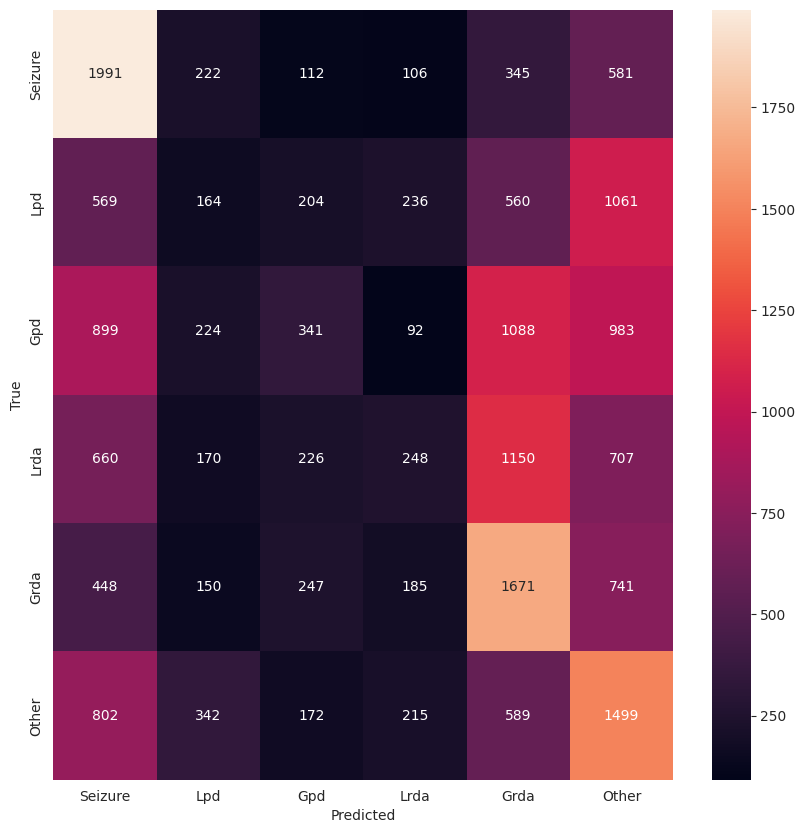

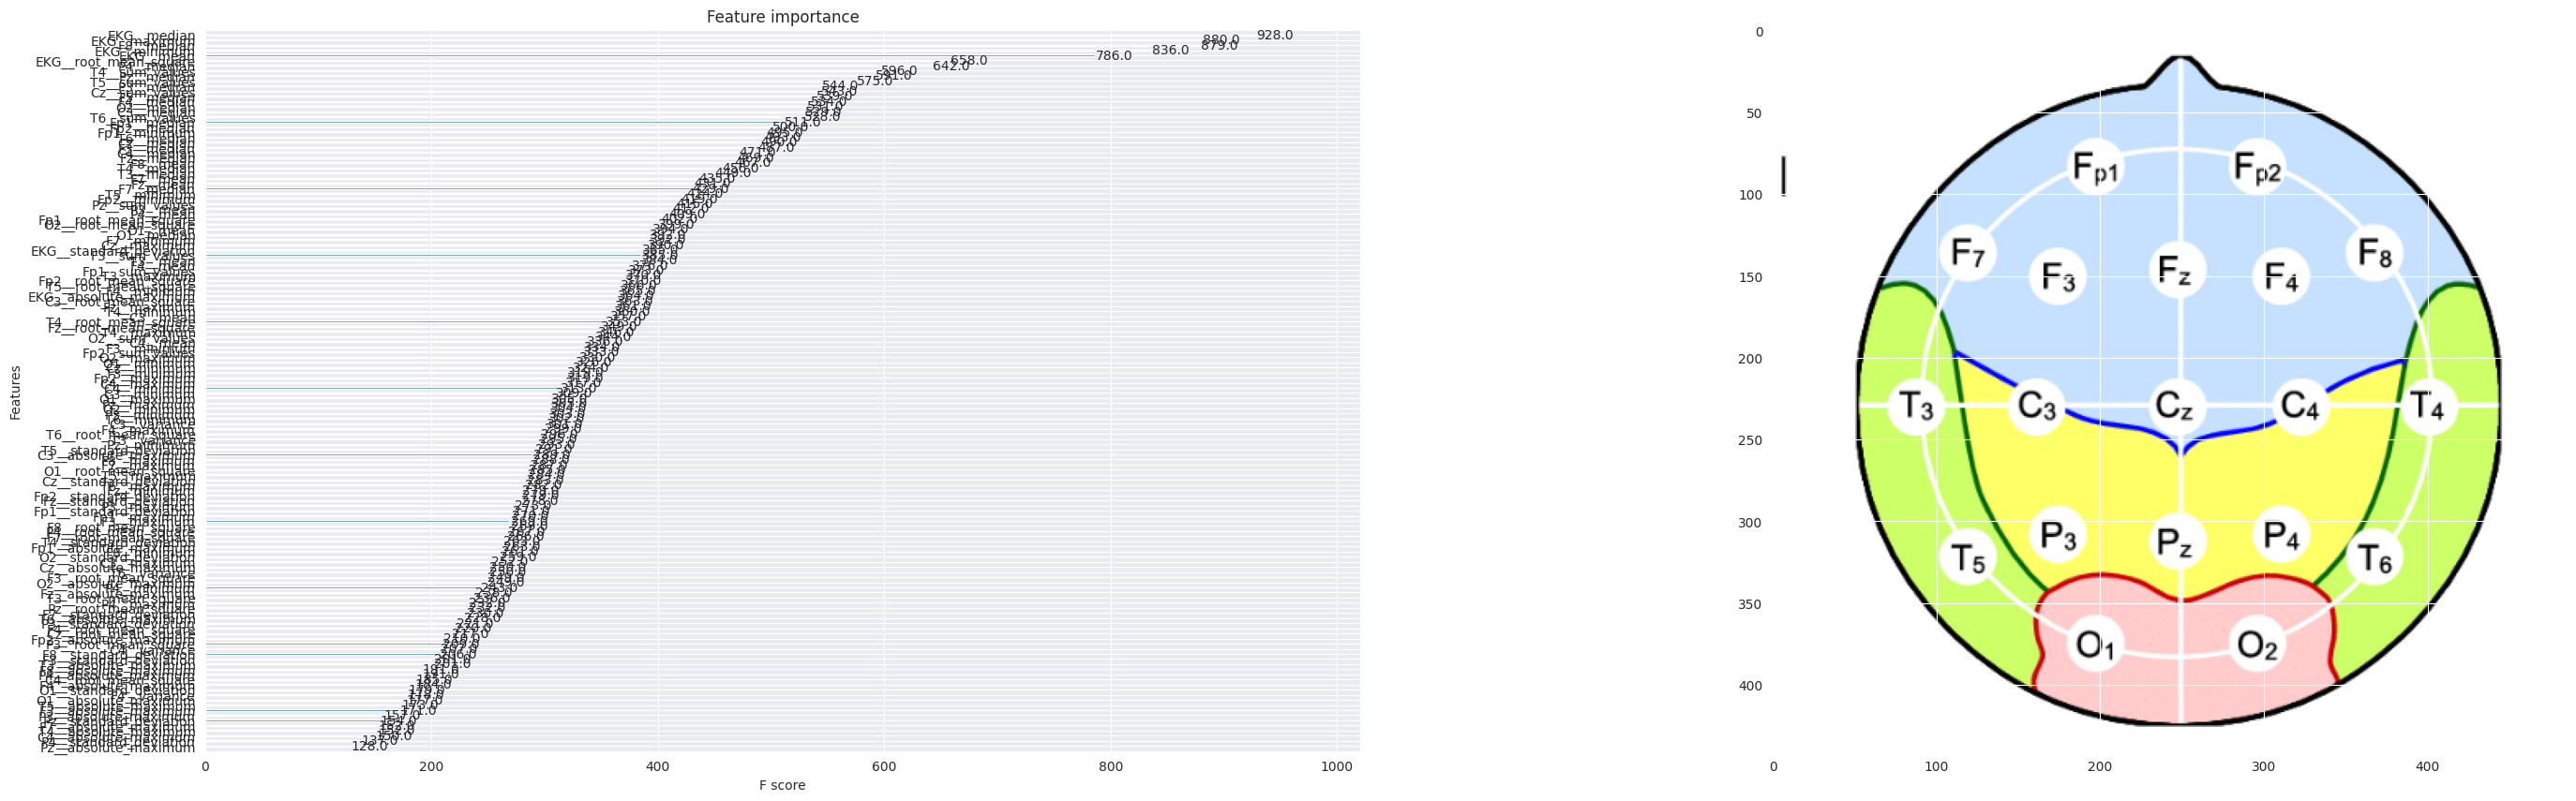

In [14]:
##Run the pipeline
model, y_pred = pipeline_tf(X_train, X_test, y_train, y_test)                          